# **ANALISIS KEMIRIPAN PERTANYAAN PENGGUNA TERHADAP FAQ SHOPEE MENGGUNAKAN METODE TEXT SIMILARITY**

Fadhila Eka Giovani    (251155014/1314622020)

Niha Nur Mayla Putri   (24031554057)

Rahmawati Dian Pratiwi (24031554183)

In [ ]:
!pip install indonlp
!pip install sastrawi
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 60.8 MB/s eta 0:00:00


In [ ]:
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.tokenize import word_tokenize
from indoNLP.preprocessing import replace_slang
from indoNLP.preprocessing import replace_word_elongation
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import requests
import json
import time
import csv
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import string
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# **SCAPPING FAQ SHOPEE**

In [ ]:
# Konfigurasi
FRONTEND_ID = 4
DEVICE_ID = "da60506c-e43b-4d7a-a252-a1b5a69a2a6c"
BASE_URL = "https://help.shopee.co.id/api/inhouse/hc/mobile/v1"
OUTPUT_CSV = "shopee_faq.csv"

headers = {
    "User-Agent": "Mozilla/5.0 (compatible; ShopeeScraper/1.0)",
    "Accept": "application/json",
}

session = requests.Session()
session.headers.update(headers)

In [ ]:
def get_json(url, params=None):
    """GET JSON dengan retry"""
    for i in range(3):
        try:
            r = session.get(url, params=params, timeout=15)
            r.raise_for_status()
            return r.json()
        except Exception as e:
            print(f"⚠️ Error: {e} (retry {i+1})")
            time.sleep(1.5)
    return None

In [ ]:
def clean_text(html):
    soup = BeautifulSoup(html, "html.parser")
    return soup.get_text(separator="\n").strip()

In [ ]:
# Ambil semua kategori
def get_all_categories():
    url = f"{BASE_URL}/categories"
    data = get_json(url, {"frontend_id": FRONTEND_ID})

    categories = []

    def walk(subdirs, parent=None):
        for c in subdirs:
            cat = {
                "id": c["id"],
                "name": c["category_name"],
                "parent": parent,
            }
            categories.append(cat)
            if c.get("sub_dir_info"):
                walk(c["sub_dir_info"], parent=c["category_name"])

    walk(data.get("dir_info", []))
    return categories

In [ ]:
# Ambil semua artikel disemua kategori
def get_articles(category_id):
    url = f"{BASE_URL}/categories/articles"
    all_articles = []
    page = 1

    while True:
        params = {
            "category_id": category_id,
            "frontend_id": FRONTEND_ID,
            "page": page,
            "size": 50,
            "device_id": DEVICE_ID,
        }
        data = get_json(url, params)
        if not data or not data.get("articles"):
            break
        all_articles.extend(data["articles"])
        if len(data["articles"]) < 50:
            break
        page += 1
        time.sleep(0.2)

    return all_articles

In [ ]:
# Ambil isi konten (content HTML)
def get_article_contents(article_ids):
    url = f"{BASE_URL}/seo"
    params = [("frontend_id", FRONTEND_ID)] + [("article_ids", i) for i in article_ids]
    r = session.get(url, params=params, timeout=20)
    r.raise_for_status()
    data = r.json()
    return data.get("articles", [])

In [ ]:
# MAIN
def main():
    print("Mengambil semua kategori...")
    categories = get_all_categories()
    print(f"Total kategori & subkategori: {len(categories)}")

    rows = []

    for cat in tqdm(categories, desc="Kategori"):
        cat_name = cat["parent"] or cat["name"]
        subcat_name = cat["name"] if cat["parent"] else "-"
        cat_id = cat["id"]

        articles = get_articles(cat_id)
        if not articles:
            continue

        ids = [str(a["id"]) for a in articles]

        for i in range(0, len(ids), 10):
            batch = ids[i:i+10]
            contents = get_article_contents(batch)

            for art in contents:
                art_id = art["id"]
                pertanyaan = art["title"].strip()
                html = art.get("content", "")
                jawaban_pertanyaan = clean_text(html).strip()

                if pertanyaan and jawaban_pertanyaan:
                    if "[FAQ]" not in pertanyaan:
                        rows.append([cat_name, subcat_name, pertanyaan, jawaban_pertanyaan])

            time.sleep(0.3)

    with open(OUTPUT_CSV, "w", encoding="utf-8-sig", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["kategori", "subkategori", "pertanyaan faq", "jawaban pertanyaan faq"])
        writer.writerows(rows)

    print(f"\n Selesai! Data disimpan di {OUTPUT_CSV}")
    print(f"Total artikel tersimpan: {len(rows)}")


if __name__ == "__main__":
    main()

Mengambil semua kategori...
Total kategori & subkategori: 51


Kategori: 100%|██████████| 51/51 [01:41<00:00,  1.99s/it]


 Selesai! Data disimpan di shopee_faq.csv
Total artikel tersimpan: 1149


# **PRE PROCESSING**

In [ ]:
df_f = pd.read_csv("shopee_faq.csv")
df_f.head()

kategori     subkategori  \
0  Belanja di Shopee  Baru di Shopee   
1  Belanja di Shopee  Baru di Shopee   
2  Belanja di Shopee  Baru di Shopee   
3  Belanja di Shopee  Baru di Shopee   
4  Belanja di Shopee  Baru di Shopee   

                                      pertanyaan faq  \
0       [Shopee Live] Apa itu Lelang di Shopee Live?   
1                    [Grosir] Apa itu Produk Grosir?   
2           [Shopee Barokah] Apa itu Shopee Barokah?   
3  [Baru di Shopee] Siapa Penjual Star atau Star+...   
4  [Shopee Live] Apa saja kategori streaming yang...   

                              jawaban pertanyaan faq  
0  Aktivitas lelang di Shopee Live memungkinkan A...  
1  Produk Grosir mengacu pada barang yang tersedi...  
2  Shopee Barokah merupakan fitur yang disediakan...  
3  Penjual Star\nPenjual Star Shopee\n adalah Pen...  
4  Untuk memastikan pengalaman yang maksimal bagi...

**preprocessed faq**

In [ ]:
def preprocess(texts):
    # Penanganan Nilai Kosong
    if pd.isna(texts) or texts is None:
        return ""
    # Lowercasing
    texts = str(texts).lower()
    # Mengganti Baris Baru menjadi Spasi
    texts = texts.replace("\n", " ")
    # Menghapus Tanda Daftar
    texts = re.sub(r'\b[a-z]\s*\.', ' ', texts)
    # Menghapus Simbol Daftar/Bullet
    texts = re.sub(r'[-•→▶►▪️•·]+', ' ', texts)
    # Menghapus Smart Quotes
    texts = re.sub(r"[“”‘’]", "", texts)
    # Menghapus Tanda Baca ASCII
    texts = texts.translate(str.maketrans("", "", string.punctuation))
    # Menghapus angka
    texts = re.sub(r'\d+',' ', texts)
    # Menghapus karakter emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F" # Emoticon
        u"\U0001F300-\U0001F5FF" # Simbol & Piktograf
        u"\U0001F680-\U0001F6FF" # Transportasi & Peta
        u"\U0001F1E0-\U0001F1FF" # Bendera (Flags)
        u"\U00002700-\U000027BF" # Simbol Tambahan
        u"\U0001F900-\U0001F9FF" # Piktograf Tambahan
        u"\U00002600-\U000026FF" # Simbol Misc
        "]+", flags=re.UNICODE)
    texts = emoji_pattern.sub(" ", texts)
    # Normalisasi Spasi Awal
    texts = re.sub(r"\s+"," ", texts).strip()
    # Tokenisasi
    words = texts.split()
    cleaned_text = " ".join(words) # Menggabungkannya kembali
    # Menghapus Token Pendek
    cleaned_text = re.sub(r'\b[a-zA-Z]{1,2}\b', ' ', cleaned_text)
    # Normalisasi Spasi Terakhir
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text

In [ ]:
cols_clean = ["kategori", "subkategori", "pertanyaan faq", "jawaban pertanyaan faq"]

def safe_replace(val):
    # Mempertahankan nilai non-scalar kompleks
    if isinstance(val, (list, dict, tuple)):
        return val
    # Mengubah NaN standar menjadi np.nan
    if pd.isna(val):
        return np.nan

    val = str(val).strip()
    # Mengubah string kosong atau string "-" menjadi np.nan
    return np.nan if val in ["", "-"] else val

# Terapkan pembersihan awal (mengubah placeholder menjadi np.nan)
for c in cols_clean:
    if c in df_f.columns:
        df_f[c] = df_f[c].apply(safe_replace)

required_cols = ["kategori", "subkategori", "pertanyaan faq", "jawaban pertanyaan faq"]
df_f = df_f.dropna(subset=required_cols) # Menghapus baris jika ada NaN di salah satu kolom ini

# Konversi tipe data akhir (setelah baris kosong dihapus)
for c in cols_clean:
    df_f[c] = df_f[c].astype(str)

df_f["preprocessed pertanyaan faq"] = df_f["pertanyaan faq"].apply(preprocess)
df_f["preprocessed jawaban faq"] = df_f["jawaban pertanyaan faq"].apply(preprocess)
df_f["combined_clean_text"] = (
    df_f["preprocessed pertanyaan faq"] + " " + df_f["preprocessed jawaban faq"]
)

df_f

kategori         subkategori  \
0     Belanja di Shopee      Baru di Shopee   
1     Belanja di Shopee      Baru di Shopee   
2     Belanja di Shopee      Baru di Shopee   
3     Belanja di Shopee      Baru di Shopee   
4     Belanja di Shopee      Baru di Shopee   
...                 ...                 ...   
1144          ShopeePay  ShopeePay Merchant   
1145          ShopeePay  ShopeePay Merchant   
1146          ShopeePay  ShopeePay Merchant   
1147          ShopeePay  ShopeePay Merchant   
1148          ShopeePay  ShopeePay Merchant   

                                         pertanyaan faq  \
0          [Shopee Live] Apa itu Lelang di Shopee Live?   
1                       [Grosir] Apa itu Produk Grosir?   
2              [Shopee Barokah] Apa itu Shopee Barokah?   
3     [Baru di Shopee] Siapa Penjual Star atau Star+...   
4     [Shopee Live] Apa saja kategori streaming yang...   
...                                                 ...   
1144        Syarat dan Ketentuan ShopeePay QRIS Speaker   
1145  [Merchant ShopeePay] Bagaimana Jika Nama Toko ...   
1146  Berapa Biaya Instalasi dan Biaya Sewa Harian u...   
1147     Bagaimana Cara Memesan ShopeePay QRIS Speaker?   
1148  [Merchant ShopeePay] Bagaimana cara mengakses ...   

                                 jawaban pertanyaan faq  \
0     Aktivitas lelang di Shopee Live memungkinkan A...   
1     Produk Grosir mengacu pada barang yang tersedi...   
2     Shopee Barokah merupakan fitur yang disediakan...   
3     Penjual Star\nPenjual Star Shopee\n adalah Pen...   
4     Untuk memastikan pengalaman yang maksimal bagi...   
...                                                 ...   
1144  Syarat dan Ketentuan ShopeePay QRIS Speaker ("...   
1145  Dengan adanya aturan baru dari PTEN terkait na...   
1146  Biaya instalasi ShopeePay QRIS Speaker adalah ...   
1147  Anda dapat melakukan pemesanan ShopeePay QRIS ...   
1148  Situs Shopee Partner adalah salah satu portal ...   

                            preprocessed pertanyaan faq  \
0                shopee live apa itu lelang shopee live   
1                          grosir apa itu produk grosir   
2                 shopee barokah apa itu shopee barokah   
3       baru shopee siapa penjual star atau star shopee   
4     shopee live apa saja kategori streaming yang d...   
...                                                 ...   
1144        syarat dan ketentuan shopeepay qris speaker   
1145  merchant shopeepay bagaimana jika nama toko ya...   
1146  berapa biaya instalasi dan biaya sewa harian u...   
1147      bagaimana cara memesan shopeepay qris speaker   
1148  merchant shopeepay bagaimana cara mengakses si...   

                               preprocessed jawaban faq  \
0     aktivitas lelang shopee live memungkinkan anda...   
1     produk grosir mengacu pada barang yang tersedi...   
2     shopee barokah merupakan fitur yang disediakan...   
3     penjual star penjual star shopee adalah penjua...   
4     untuk memastikan pengalaman yang maksimal bagi...   
...                                                 ...   
1144  syarat dan ketentuan shopeepay qris speaker sy...   
1145  dengan adanya aturan baru dari pten terkait na...   
1146  biaya instalasi shopeepay qris speaker adalah ...   
1147  anda dapat melakukan pemesanan shopeepay qris ...   
1148  situs shopee partner adalah salah satu portal ...   

                                    combined_clean_text  
0     shopee live apa itu lelang shopee live aktivit...  
1     grosir apa itu produk grosir produk grosir men...  
2     shopee barokah apa itu shopee barokah shopee b...  
3     baru shopee siapa penjual star atau star shope...  
4     shopee live apa saja kategori streaming yang d...  
...                                                 ...  
1144  syarat dan ketentuan shopeepay qris speaker sy...  
1145  merchant shopeepay bagaimana jika nama toko ya...  
1146  berapa biaya instalasi dan biaya sewa harian u...  
1147  bagaimana cara memesan shope

**preprocessed pertanyaan pengguna**

In [ ]:
CUSTOM_NORMALIZATION_MAP = {
    "step": "langkah",
    "balikin": "pengembalian",
    "kalo": "kalau",
    "pesenan": "pesanan",
    "cancel": "batal",
    "minus": "berkurang",
    "failed": "gagal",
    "refund": "kembali",
    "ngaktifin": "mengaktifkan",
    "duitnya": "uangnya",
    "terus": "selalu",
    "pick": "mengambil",
    "reject": "rusak",
    "retur": "kembalikan",
    "approve": "disetujui",
    "selalu": "lalu",
    "gbisa": "gabisa",
    "lasan": "ulasan",
    "crara": "cara",
    "ngambil": "penarikan",
    "pakai": "menggunakan",
    "beli": "membeli",
    "harus": "dapat",
    "kena": "dikenakan",
    "shope":"shopee"
}

def normalize_custom_words(tokens, custom_map):
    normalized_tokens = [custom_map.get(t, t) for t in tokens]
    return normalized_tokens

manual_stop_words = set([
    'dan', 'min', 'sih', 'ku', 'aku', 'overseas', 'up'
])
filtered_stop_words = manual_stop_words

def preprocess_pengguna(text):
  # Penanganan Nilai Kosong
    if pd.isna(text) or text is None:
        return ""
    # Lowercasing
    text = str(text).lower()
    # Menghapus Punctuation dan Simbol
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    # Menghapus Angka
    text = re.sub(r"\d+", " ", text)
    # Normalisasi Spasi Awal
    text = re.sub(r"\s+", " ", text).strip()
    # Mengatasi Perpanjangan Kata
    text = replace_word_elongation(text)
    # Mengatasi Kata Slang
    text = replace_slang(text)
    # Tokenisasi
    tokens = word_tokenize(text)
    # Normalisasi Kustom
    tokens = normalize_custom_words(tokens, CUSTOM_NORMALIZATION_MAP)
    # Penghapusan Stopword Otomatis dan Manual
    tokens = [t for t in tokens if t not in filtered_stop_words]
    # Penggabungan Kembali
    cleaned_text = " ".join(tokens)
    # Normalisasi Spasi Akhir
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text

with open("pertanyaan_pengguna.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()

df_q = pd.DataFrame([line.strip() for line in lines if line.strip()], columns=["question"])
df_q["question_clean"] = df_q["question"].apply(preprocess_pengguna)
df_q

question  \
0   ﻿Gimana step-nya bayar pesenan tapi pake Seabank?   
1             gimana cara balikin dana Tiket Bioskop?   
2   Cara transfer ke temen yang sesama Pengguna Sh...   
3   gimana sih cara ngambil uang dari Saldo mitra ...   
4          Top up ShopeePay bisa lewat mana aja, min?   
5             cara pake Voucher ShopeeFood gimana sih   
6   kalo barang pesanan udah sampe dan udah di pes...   
7             Pake sPayLater limit xtra aman gak sih?   
8       Gimana cara ngaktifin SPayLater buat belanja?   
9                  kok aku gabisa bayar pake  COD sih   
10                alamat yang salah bisa di-edit gak?   
11  kenapa sih kok Voucher Gratis Ongkir ku gbisa ...   
12       cara  ngirim gambar di fitur chat gimana ya?   
13            kalau pesenan COD gagal gimana sih min?   
14  gimana caranya biar ga kena  modus penipuan tr...   
15                          klaim Proteksi hp gimana?   
16  crara supaya ga kena modus penipuan lewat chat...   
17  maksimal berat Kirim Hemat Kargo Ekonomis bera...   
18            Syarat SPinjam buat Penjual tuh apa sih   
19  setelah penilaian produk kita tuh tetep bisa n...   
20  apa aja dokumen yang harus saya kirimkan buat ...   
21  kalau belum nerima pengembalian dana padahal u...   
22  cara tau kalau pengembalian dana udah masuk ke...   
23  Berapa lama ya proses pengecekan barang buat p...   
24               beli produk di Shopee kena pajak ga?   
25  Beli barang grosir di Shopee itu apa bedanya s...   
26  Iklan Shopee Live itu apaan sih, buat promosi ...   
27  Kalau mau nge-chat atau nanya-nanya ke penjual...   
28   Lelang di Shopee Live itu maksudnya gimana, sih?   
29  Emang kenapa kalau Live di Shopee pakai video ...   
30  Penjual Star/Star+ di Shopee itu siapa, pentin...   
31  Misi Shopee Meter itu tugasnya apa, biar skor ...   
32  Gimana cara dapetin koin gratis dari Program S...   
33  Shopee Barokah itu apa, jualan barang halal aj...   
34  Aturan khusus buat Live dan Shopee Video pas b...   
35  Bikin nama toko di Shopee, ada syarat khususny...   
36  Cara hapus atau ubah produk di keranjang belan...   
37  Kalau mau cari produk pakai Kode Produk di Sho...   
38  Kenapa ya akun Shopee Video-ku dibatasi, jadi ...   
39       Misi-misi di Shopee Meter itu buat apa, sih?   
40  Live yang dianggap konten jelek di Shopee Live...   
41  Cara top up saldo buat ShopeePay Merchant itu ...   
42  Voucher buat nyobain sample produk gratis di S...   
43  Cara bikin Iklan Live di Shopee lewat aplikasi...   
44  Biar Iklan Live Shopee kita efektif, cara kerj...   
45  Boleh nggak sih ngadain event Gacha-gacha berh...   
46  Kesehatan Video di Shopee Video itu maksudnya ...   
47  Kalau ada yang nyolong Hak Cipta (HAKI) pas Li...   
48  apa bedanya pesanan yang 'Langsung' sama yang ...   
49  Cara lihat dan download faktur biaya iklan Sho...   

                                       question_clean  
0   bagaimana langkah nya bayar pesanan tapi mengg...  
1      bagaimana cara pengembalian dana tiket bioskop  
2   cara transfer ke teman yang sesama pengguna sh...  
3   bagaimana cara penarikan uang dari saldo mitra...  
4                  top shopeepay bisa lewat mana saja  
5       cara menggunakan voucher shopeefood bagaimana  
6   kalau barang pesanan sudah sampai sudah di pes...  
7        menggunakan spaylater limit xtra aman enggak  
8   bagaimana cara mengaktifkan spaylater buat bel...  
9               kok enggak bisa bayar menggunakan cod  
10              alamat yang salah bisa di edit enggak  
11  kenapa kok voucher gratis ongkir gabisa dipaka...  
12    cara mengirim gambar di fitur chat bagaimana ya  
13                  kalau pesanan cod gagal bagaimana  
14  bagaimana caranya biar enggak dikenakan modus ...  
15                        klaim proteksi hp bagaimana  
16  cara supaya enggak dikenakan modus penipuan le...  
17  maksimal berat kirim hemat kargo ekonomis bera...  
18                syarat spinjam buat penjual tuh apa  
19  setelah penil

# **EDA hasil pre-processing**

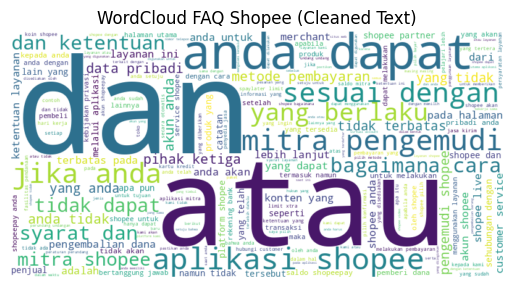

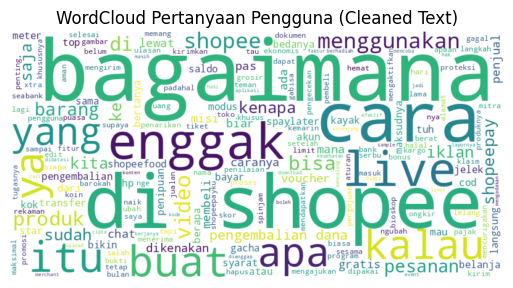

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Gabungkan seluruh teks FAQ (menggunakan kolom gabungan dari FAQ dan Jawaban)
faq_text = " ".join(df_f['combined_clean_text'])

# WordCloud FAQ Shopee
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("WordCloud FAQ Shopee (Cleaned Text)")
wc_faq = WordCloud(width=800, height=400, background_color='white').generate(faq_text)
plt.imshow(wc_faq, interpolation='bilinear')
plt.axis("off")

# Gabungkan seluruh teks pertanyaan pengguna yang sudah dibersihkan
user_text = " ".join(df_q['question_clean'])

# WordCloud Pertanyaan Pengguna
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.title("WordCloud Pertanyaan Pengguna (Cleaned Text)")
wc_user = WordCloud(width=800, height=400, background_color='white').generate(user_text)
plt.imshow(wc_user, interpolation='bilinear')
plt.axis("off")

plt.show()

In [ ]:
from collections import Counter

# Gabungkan semua token dari kedua dataframe
all_tokens_faq = [token for sublist in df_f['faq_tokens'].tolist() for token in sublist]
all_tokens_query = [token for sublist in df_q['q_tokens'].tolist() for token in sublist]

# Hitung jumlah kata unik
vocab_faq = len(set(all_tokens_faq))
vocab_query = len(set(all_tokens_query))

print(f"Jumlah Total Dokumen FAQ: {len(df_f)}")
print(f"Ukuran Kosakata Unik (FAQ): {vocab_faq} kata")
print(f"\nJumlah Total Pertanyaan Pengguna: {len(df_q)}")
print(f"Ukuran Kosakata Unik (Kueri): {vocab_query} kata")

Jumlah Total Dokumen FAQ: 1149
Ukuran Kosakata Unik (FAQ): 8079 kata
['shopee', 'live', 'apa', 'itu', 'lelang', 'shopee', 'live', 'aktivitas', 'lelang', 'shopee', 'live', 'memungkinkan', 'anda', 'untuk', 'memenangkan', 'penawaran', 'produk', 'yang', 'ditetapkan', 'oleh', 'host', 'penjual', 'setelah', 'penjual', 'memulai', 'lelang', 'kartu', 'lelang', 'akan', 'muncul', 'layar', 'anda', 'kartu', 'ini', 'menunjukkan', 'jenis', 'lelang', 'dan', 'penghitung', 'waktu', 'mundur', 'yang', 'sudah', 'ditentukan', 'oleh', 'penjual', 'sebagai', 'batas', 'akhir', 'anda', 'untuk', 'melakukan', 'penawaran', 'untuk', 'berpartisipasi', 'pilih', 'gabung', 'sekarang', 'setelah', 'kartu', 'lelang', 'berubah', 'menjadi', 'oranye', 'setelah', 'lelang', 'selesai', 'urutan', 'pemenang', 'dapat', 'dilihat', 'dengan', 'memilih', 'ikon', 'lelang', 'nama', 'pemenang', 'yang', 'dimunculkan', 'hanya', 'orang', 'yang', 'tercepat', 'catatan', 'beberapa', 'lelang', 'hanya', 'terbuka', 'untuk', 'pengikut', 'toko', 'iku

Mengetahui seberapa panjang rata-rata setiap dokumen (FAQ) dan pertanyaan pengguna.


Statistik Panjang Dokumen FAQ:
count     1149.000000
mean       298.849434
std        902.227326
min         13.000000
25%         91.000000
50%        141.000000
75%        236.000000
max      16707.000000
Name: len_faq, dtype: float64


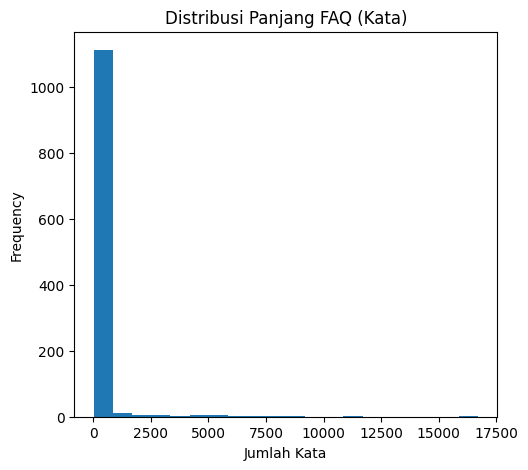


Statistik Panjang Pertanyaan Pengguna:
count    50.000000
mean      9.220000
std       2.435201
min       4.000000
25%       8.000000
50%       9.000000
75%      11.000000
max      14.000000
Name: len_query, dtype: float64


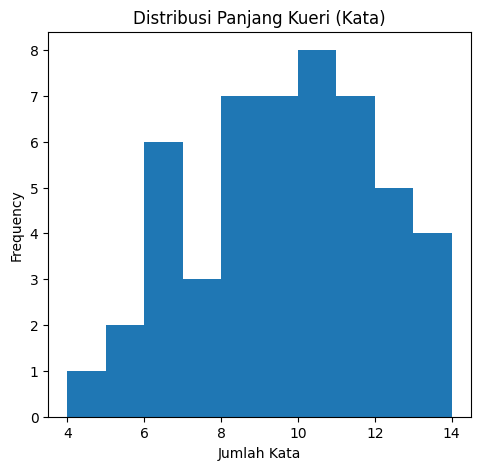

In [ ]:
# Hitung Panjang Dokumen
df_f['len_faq'] = df_f['faq_tokens'].apply(len)
df_q['len_query'] = df_q['q_tokens'].apply(len)

# Statistik Deskriptif
print("\nStatistik Panjang Dokumen FAQ:")
print(df_f['len_faq'].describe())
# Visualisasi (Histogram)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_f['len_faq'].plot(kind='hist', bins=20, title='Distribusi Panjang FAQ (Kata)')
plt.xlabel('Jumlah Kata')
plt.show()

print("\nStatistik Panjang Pertanyaan Pengguna:")
print(df_q['len_query'].describe())
# Visualisasi (Histogram)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
df_q['len_query'].plot(kind='hist', bins=10, title='Distribusi Panjang Kueri (Kata)')
plt.xlabel('Jumlah Kata')
plt.show()

Menampilkan frasa kunci yang terdiri dari dua kata (Bigram) yang sering muncul.


Bigram Teratas FAQ:


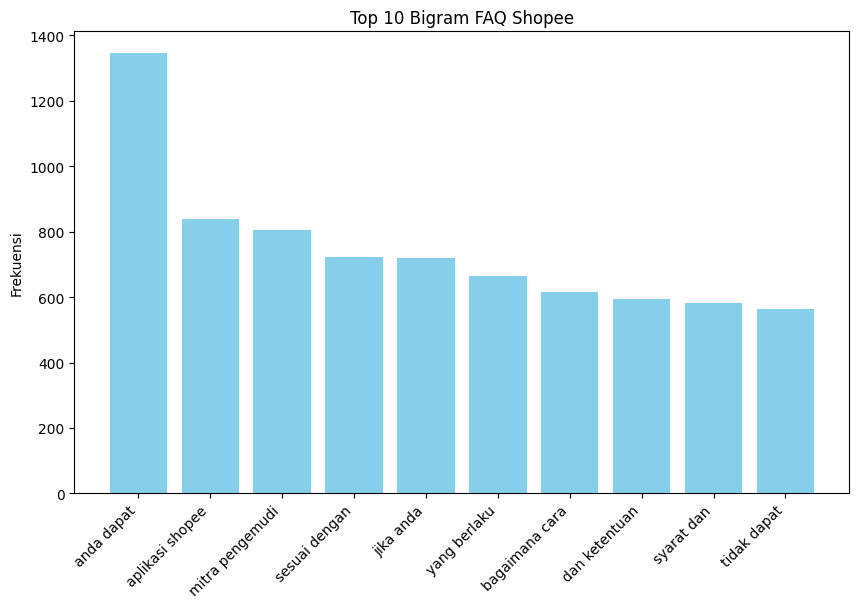


Bigram Teratas Pertanyaan Pengguna:


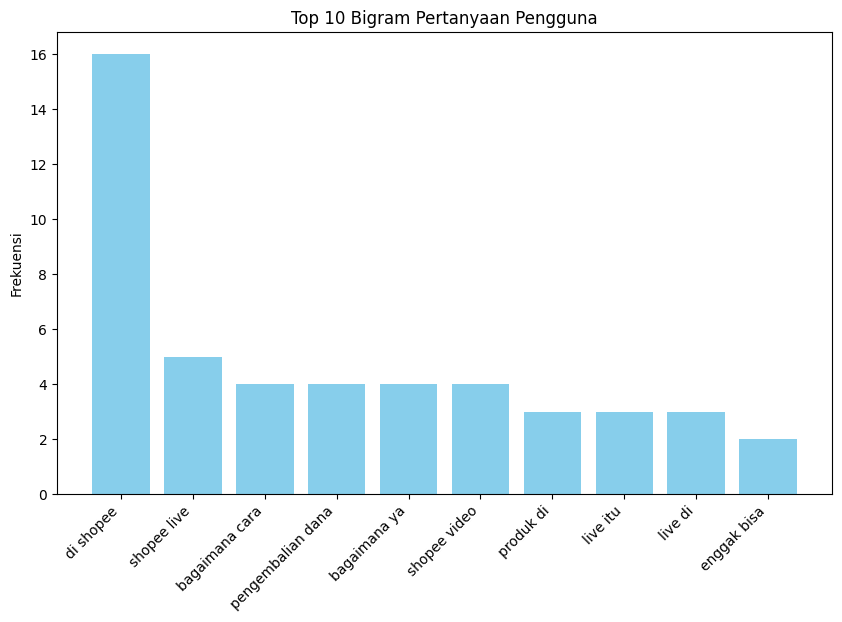

In [ ]:
# Bigram Teratas
from nltk.util import ngrams

# Fungsi untuk mendapatkan N-gram
def get_top_ngrams(corpus, n=2, top_k=20):
    all_ngrams = []
    for doc in corpus:
        all_ngrams.extend([' '.join(grams) for grams in ngrams(doc, n)])

    ngram_counts = Counter(all_ngrams)
    return ngram_counts.most_common(top_k)

# Dapatkan 10 Bigram Teratas untuk FAQ
top_bigrams_faq = get_top_ngrams(df_f['faq_tokens'].tolist(), n=2, top_k=10)

# Dapatkan 10 Bigram Teratas untuk Kueri
top_bigrams_query = get_top_ngrams(df_q['q_tokens'].tolist(), n=2, top_k=10)

# Visualisasi (Bar Chart)
def plot_ngrams(ngrams_data, title):
    words, counts = zip(*ngrams_data)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.ylabel('Frekuensi')
    plt.show()

print("\nBigram Teratas FAQ:")
plot_ngrams(top_bigrams_faq, "Top 10 Bigram FAQ Shopee")

print("\nBigram Teratas Pertanyaan Pengguna:")
plot_ngrams(top_bigrams_query, "Top 10 Bigram Pertanyaan Pengguna")

# **Feature Engineering**

# TF-IDF

**Unigram**

In [ ]:
unigram_vectorizer = TfidfVectorizer(
    ngram_range=(1,1)
)

unigram_matrix = unigram_vectorizer.fit_transform(df_f['combined_clean_text'])
unigram_features = unigram_vectorizer.get_feature_names_out()
unigram_df = pd.DataFrame(unigram_matrix.toarray(), columns=unigram_features)

unigram_df.head()

aaplikasi  abadi  abaikan  abc  abcd  abcde  abnormal  absolut  abu  acak  \
0        0.0    0.0      0.0  0.0   0.0    0.0       0.0      0.0  0.0   0.0   
1        0.0    0.0      0.0  0.0   0.0    0.0       0.0      0.0  0.0   0.0   
2        0.0    0.0      0.0  0.0   0.0    0.0       0.0      0.0  0.0   0.0   
3        0.0    0.0      0.0  0.0   0.0    0.0       0.0      0.0  0.0   0.0   
4        0.0    0.0      0.0  0.0   0.0    0.0       0.0      0.0  0.0   0.0   

   ...     zakat  zalora  zat  zis    ziswaf  zona  zone  zpa  zuama  zulhijah  
0  ...  0.000000     0.0  0.0  0.0  0.000000   0.0   0.0  0.0    0.0       0.0  
1  ...  0.000000     0.0  0.0  0.0  0.000000   0.0   0.0  0.0    0.0       0.0  
2  ...  0.037612     0.0  0.0  0.0  0.150374   0.0   0.0  0.0    0.0       0.0  
3  ...  0.000000     0.0  0.0  0.0  0.000000   0.0   0.0  0.0    0.0       0.0  
4  ...  0.000000     0.0  0.0  0.0  0.000000   0.0   0.0  0.0    0.0       0.0  

[5 rows x 8050 columns]

**Bigram**

In [ ]:
# Bigram analysis
bigram_vectorizer = TfidfVectorizer(ngram_range=(2, 2))
bigram_matrix = bigram_vectorizer.fit_transform(df_f['combined_clean_text'])
bigram_features = bigram_vectorizer.get_feature_names_out()
bigram_df = pd.DataFrame(bigram_matrix.toarray(), columns=bigram_features)
print("\nBigram Analysis:")
bigram_df.head()


Bigram Analysis:


aaplikasi mitra  abadi seluruh  abaikan jika  abaikan pesan  abc def  \
0              0.0            0.0           0.0            0.0      0.0   
1              0.0            0.0           0.0            0.0      0.0   
2              0.0            0.0           0.0            0.0      0.0   
3              0.0            0.0           0.0            0.0      0.0   
4              0.0            0.0           0.0            0.0      0.0   

   abcd dan  abcde atau  abcde rincian  abnormal atas  abnormal pada  ...  \
0       0.0         0.0            0.0            0.0            0.0  ...   
1       0.0         0.0            0.0            0.0            0.0  ...   
2       0.0         0.0            0.0            0.0            0.0  ...   
3       0.0         0.0            0.0            0.0            0.0  ...   
4       0.0         0.0            0.0            0.0            0.0  ...   

   ziswaf pilih  ziswaf prinsip  ziswaf zakat  zona pengguna  zona waktu  \
0           0.0        0.000000      0.000000            0.0         0.0   
1           0.0        0.000000      0.000000            0.0         0.0   
2           0.0        0.050029      0.050029            0.0         0.0   
3           0.0        0.000000      0.000000            0.0         0.0   
4           0.0        0.000000      0.000000            0.0         0.0   

   zona yang  zone yang  zpa android  zuama dan  zulhijah pada  
0        0.0        0.0          0.0        0.0            0.0  
1        0.0        0.0          0.0        0.0            0.0  
2        0.0        0.0          0.0        0.0            0.0  
3        0.0        0.0          0.0        0.0            0.0  
4        0.0        0.0          0.0        0.0            0.0  

[5 rows x 85495 columns]

# Word2Vec

In [ ]:
# Tokenize FAQ untuk training
sentences = [word_tokenize(text) for text in df_f["combined_clean_text"]]

# Train model Word2Vec
model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
)

model.save('word2vec.w2v')
model = Word2Vec.load('word2vec.w2v')

print("Jumlah kata dalam W2V:", len(model.wv.index_to_key))

Jumlah kata dalam W2V: 8079


In [ ]:
def get_vector(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if len(vectors) else np.zeros(model.vector_size)

df_f["faq_tokens"] = df_f["combined_clean_text"].apply(lambda x: word_tokenize(x.lower()))
df_f["faq_vector"] = df_f["faq_tokens"].apply(lambda x: get_vector(x, model))
faq_vectors = np.vstack(df_f["faq_vector"].values)

In [ ]:
df_q["q_tokens"] = df_q["question_clean"].apply(lambda x: word_tokenize(x.lower()))
df_q["q_vector"] = df_q["q_tokens"].apply(lambda x: get_vector(x, model))
q_vectors = np.vstack(df_q["q_vector"].values)

faq_vectors.shape, q_vectors.shape

((1149, 100), (50, 100))

# **EDA hasil feature engineering**


**WordCloud TF-IDF Unigram FAQ & User Query**

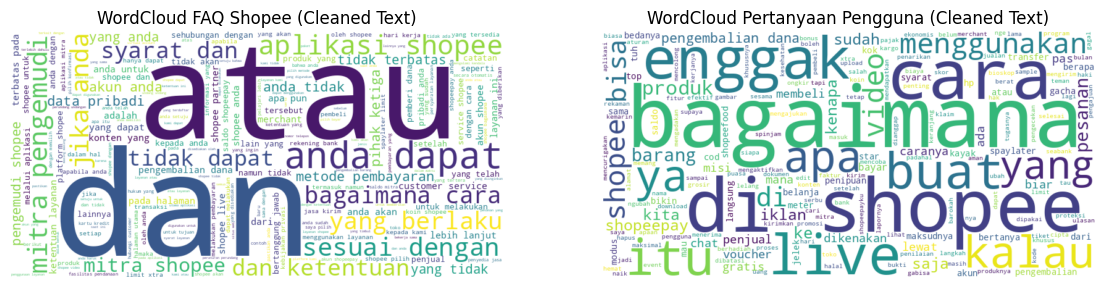

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan seluruh teks FAQ (menggunakan kolom gabungan dari FAQ dan Jawaban)
faq_text = " ".join(df_f['combined_clean_text'])

# Gabungkan seluruh teks pertanyaan pengguna yang sudah dibersihkan
user_text = " ".join(df_q['question_clean'])

## Visualisasi WordCloud
plt.figure(figsize=(14, 6))

# Plot 1: WordCloud FAQ Shopee
plt.subplot(1, 2, 1)
plt.title("WordCloud FAQ Shopee (Cleaned Text)")
wc_faq = WordCloud(width=800, height=400, background_color='white').generate(faq_text)
plt.imshow(wc_faq, interpolation='bilinear')
plt.axis("off")

# Plot 2: WordCloud Pertanyaan Pengguna
plt.subplot(1, 2, 2)
plt.title("WordCloud Pertanyaan Pengguna (Cleaned Text)")
wc_user = WordCloud(width=800, height=400, background_color='white').generate(user_text)
plt.imshow(wc_user, interpolation='bilinear')
plt.axis("off")

plt.show()

**Sparsity Matrix TF-IDF**

Word2Vec tidak menghasilkan matriks sparse besar seperti TF-IDF, melainkan menghasilkan dense vector. Jadi hanya akan divisualisasikan sparsity untuk model TF-IDF Unigram dan Bigram.

Sparsity FAQ TF-IDF UNIGRAM: 0.9871
Sparsity FAQ TF-IDF BIGRAM: 0.9975


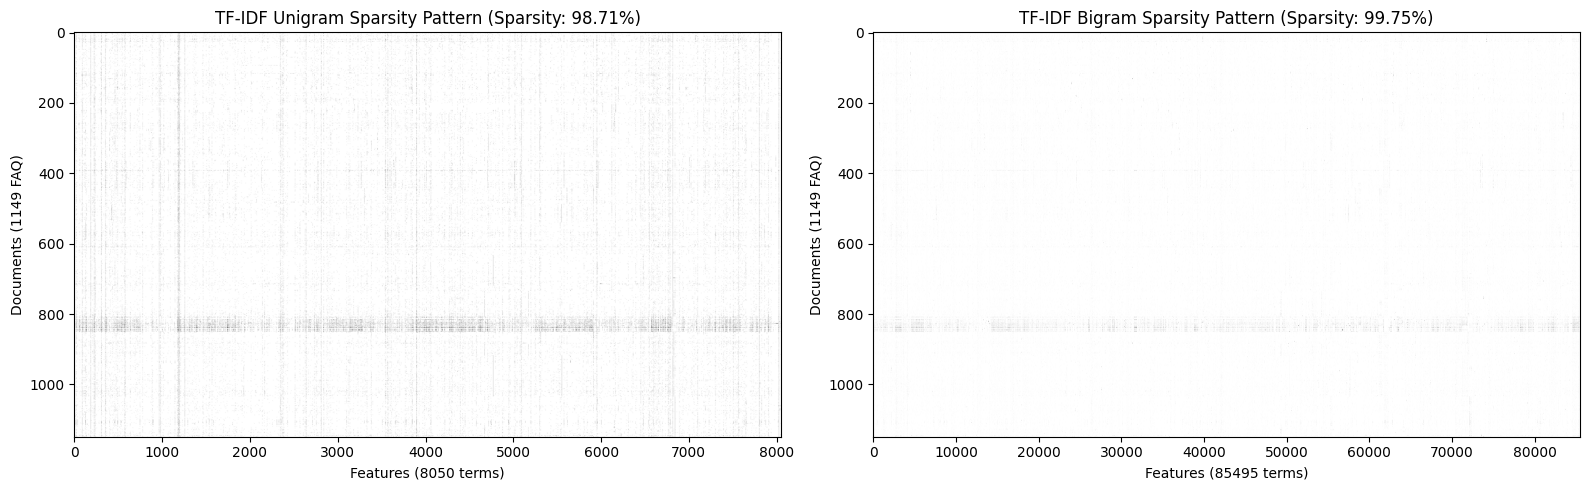

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# TF-IDF UNIGRAM
sparsity_unigram = 1.0 - (unigram_matrix.nnz / (unigram_matrix.shape[0] * unigram_matrix.shape[1]))
print(f"Sparsity FAQ TF-IDF UNIGRAM: {sparsity_unigram:.4f}")

# TF-IDF BIGRAM
sparsity_bigram = 1.0 - (bigram_matrix.nnz / (bigram_matrix.shape[0] * bigram_matrix.shape[1]))
print(f"Sparsity FAQ TF-IDF BIGRAM: {sparsity_bigram:.4f}")

plt.figure(figsize=(16, 5))

# Plot 1: Unigram Sparsity
plt.subplot(1, 2, 1)
plt.imshow(unigram_matrix.toarray() != 0, aspect='auto', cmap='gray_r')
plt.title(f"TF-IDF Unigram Sparsity Pattern (Sparsity: {sparsity_unigram:.2%})")
plt.xlabel(f"Features ({unigram_matrix.shape[1]} terms)")
plt.ylabel(f"Documents ({unigram_matrix.shape[0]} FAQ)")
plt.tight_layout()

# Plot 2: Bigram Sparsity
plt.subplot(1, 2, 2)
plt.imshow(bigram_matrix.toarray() != 0, aspect='auto', cmap='gray_r')
plt.title(f"TF-IDF Bigram Sparsity Pattern (Sparsity: {sparsity_bigram:.2%})")
plt.xlabel(f"Features ({bigram_matrix.shape[1]} terms)")
plt.ylabel(f"Documents ({bigram_matrix.shape[0]} FAQ)")
plt.tight_layout()

plt.show()

# **Similarity**

Cosine Similarity (tf-idf unigram)

In [ ]:
q_tfidf = unigram_vectorizer.transform(df_q["question_clean"])
sim_to_faq = cosine_similarity(q_tfidf, unigram_matrix)

top_k = 3
top_k_indices = np.argsort(sim_to_faq, axis=1)[:, -top_k:][:, ::-1]

all_results = []

for i, row in df_q.iterrows():
    q_original = row["question"]

    indices = top_k_indices[i]
    scores = sim_to_faq[i, indices]

    faq_titles = df_f.iloc[indices]["pertanyaan faq"].values
    faq_contents = df_f.iloc[indices]["jawaban pertanyaan faq"].values

    for rank in range(top_k):
        all_results.append({
            "question": q_original,
            f"rank_{rank+1}_pertanyaan_faq": faq_titles[rank],
            f"rank_{rank+1}_jawaban_faq": faq_contents[rank],
            f"rank_{rank+1}_similarity_score": scores[rank]
        })

df_q_result = df_q[["question"]].copy()
for k in range(top_k):
    indices = top_k_indices[:, k]
    scores = sim_to_faq[np.arange(len(df_q)), indices]
    df_q_result[f"faq_judul_rank_{k+1}"] = df_f.iloc[indices]["pertanyaan faq"].values
    df_q_result[f"faq_jawaban_rank_{k+1}"] = df_f.iloc[indices]["jawaban pertanyaan faq"].values
    df_q_result[f"similarity_score_rank_{k+1}"] = scores
df_result_top3_unigram = df_q_result[[
    "question",
    "faq_judul_rank_1", "similarity_score_rank_1",
    "faq_judul_rank_2", "similarity_score_rank_2",
    "faq_judul_rank_3", "similarity_score_rank_3",
]]
df_result_top3_unigram

question  \
0   ﻿Gimana step-nya bayar pesenan tapi pake Seabank?   
1             gimana cara balikin dana Tiket Bioskop?   
2   Cara transfer ke temen yang sesama Pengguna Sh...   
3   gimana sih cara ngambil uang dari Saldo mitra ...   
4          Top up ShopeePay bisa lewat mana aja, min?   
5             cara pake Voucher ShopeeFood gimana sih   
6   kalo barang pesanan udah sampe dan udah di pes...   
7             Pake sPayLater limit xtra aman gak sih?   
8       Gimana cara ngaktifin SPayLater buat belanja?   
9                  kok aku gabisa bayar pake  COD sih   
10                alamat yang salah bisa di-edit gak?   
11  kenapa sih kok Voucher Gratis Ongkir ku gbisa ...   
12       cara  ngirim gambar di fitur chat gimana ya?   
13            kalau pesenan COD gagal gimana sih min?   
14  gimana caranya biar ga kena  modus penipuan tr...   
15                          klaim Proteksi hp gimana?   
16  crara supaya ga kena modus penipuan lewat chat...   
17  maksimal berat Kirim Hemat Kargo Ekonomis bera...   
18            Syarat SPinjam buat Penjual tuh apa sih   
19  setelah penilaian produk kita tuh tetep bisa n...   
20  apa aja dokumen yang harus saya kirimkan buat ...   
21  kalau belum nerima pengembalian dana padahal u...   
22  cara tau kalau pengembalian dana udah masuk ke...   
23  Berapa lama ya proses pengecekan barang buat p...   
24               beli produk di Shopee kena pajak ga?   
25  Beli barang grosir di Shopee itu apa bedanya s...   
26  Iklan Shopee Live itu apaan sih, buat promosi ...   
27  Kalau mau nge-chat atau nanya-nanya ke penjual...   
28   Lelang di Shopee Live itu maksudnya gimana, sih?   
29  Emang kenapa kalau Live di Shopee pakai video ...   
30  Penjual Star/Star+ di Shopee itu siapa, pentin...   
31  Misi Shopee Meter itu tugasnya apa, biar skor ...   
32  Gimana cara dapetin koin gratis dari Program S...   
33  Shopee Barokah itu apa, jualan barang halal aj...   
34  Aturan khusus buat Live dan Shopee Video pas b...   
35  Bikin nama toko di Shopee, ada syarat khususny...   
36  Cara hapus atau ubah produk di keranjang belan...   
37  Kalau mau cari produk pakai Kode Produk di Sho...   
38  Kenapa ya akun Shopee Video-ku dibatasi, jadi ...   
39       Misi-misi di Shopee Meter itu buat apa, sih?   
40  Live yang dianggap konten jelek di Shopee Live...   
41  Cara top up saldo buat ShopeePay Merchant itu ...   
42  Voucher buat nyobain sample produk gratis di S...   
43  Cara bikin Iklan Live di Shopee lewat aplikasi...   
44  Biar Iklan Live Shopee kita efektif, cara kerj...   
45  Boleh nggak sih ngadain event Gacha-gacha berh...   
46  Kesehatan Video di Shopee Video itu maksudnya ...   
47  Kalau ada yang nyolong Hak Cipta (HAKI) pas Li...   
48  apa bedanya pesanan yang 'Langsung' sama yang ...   
49  Cara lihat dan download faktur biaya iklan Sho...   

                                     faq_judul_rank_1  \
0   [Pembayaran Pesanan] Bagaimana cara membayar p...   
1   [Tiket Bioskop] Bagaimana cara membeli Tiket B...   
2   [Transfer ShopeePay] Bagaimana cara menerima s...   
3   [Mitra Shopee] Bagaimana cara menambahkan/mend...   
4   [Mitra Shopee] Bagaimana cara mengisi saldo Sh...   
5   [Voucher] Bagaimana cara menggunakan Voucher s...   
6   [Pengembalian Barang/Dana] Apakah saya dapat m...   
7   [SPayLater Limit Xtra] Apakah QR ShopeePay dan...   
8   [SPayLater Limit Xtra - Limit & Aktivasi] Baga...   
9   [Bayar di Tempat] Bagaimana cara melakukan pem...   
10  [Akun Saya] Bagaimana cara menambah/mengedit/m...   
11             [Gratis Ongkir] Apa itu Gratis Ongkir?   
12                   [Chat] Apa itu Pelanggaran Chat?   
13  [Bayar di Tempat] Bagaimana cara melakukan pem...   
14  [Mitra Pengemudi Shopee] Bagaimana cara menghi...   
15  [Proteksi Furnitur] Bagaimana cara melakukan k...   
16  [Mitra Pengemudi Shopee] Bagaimana cara menghi...   
17  [Jasa Kirim] Apa itu Jasa Kirim Hemat Kargo Ek...   
18  [SPinjam untuk Penjual] Bagaimana cara mengaju... 

Cosine Similarity (tf-idf bigram)

In [ ]:
q_tfidf = bigram_vectorizer.transform(df_q['question_clean'])
sim_to_faq = cosine_similarity(q_tfidf, bigram_matrix)

top_k = 3
top_k_indices = np.argsort(sim_to_faq, axis=1)[:, -top_k:][:, ::-1]

all_results = []

for i, row in df_q.iterrows():
    q_original = row["question"]
    indices = top_k_indices[i]
    scores = sim_to_faq[i, indices]
    faq_titles = df_f.iloc[indices]["pertanyaan faq"].values
    faq_contents = df_f.iloc[indices]["jawaban pertanyaan faq"].values
    for rank in range(top_k):
        all_results.append({
            "question": q_original,
            f"rank_{rank+1}_pertanyaan_faq": faq_titles[rank],
            f"rank_{rank+1}_jawaban_faq": faq_contents[rank],
            f"rank_{rank+1}_similarity_score": scores[rank]
        })

df_q_result = df_q[["question"]].copy()
for k in range(top_k):
    indices = top_k_indices[:, k]
    scores = sim_to_faq[np.arange(len(df_q)), indices]

    df_q_result[f"faq_judul_rank_{k+1}"] = df_f.iloc[indices]["pertanyaan faq"].values
    df_q_result[f"faq_jawaban_rank_{k+1}"] = df_f.iloc[indices]["jawaban pertanyaan faq"].values
    df_q_result[f"similarity_score_rank_{k+1}"] = scores
df_result_top3_bigram = df_q_result[[
    "question",
    "faq_judul_rank_1", "similarity_score_rank_1",
    "faq_judul_rank_2", "similarity_score_rank_2",
    "faq_judul_rank_3", "similarity_score_rank_3",
]]
df_result_top3_bigram

question  \
0   ﻿Gimana step-nya bayar pesenan tapi pake Seabank?   
1             gimana cara balikin dana Tiket Bioskop?   
2   Cara transfer ke temen yang sesama Pengguna Sh...   
3   gimana sih cara ngambil uang dari Saldo mitra ...   
4          Top up ShopeePay bisa lewat mana aja, min?   
5             cara pake Voucher ShopeeFood gimana sih   
6   kalo barang pesanan udah sampe dan udah di pes...   
7             Pake sPayLater limit xtra aman gak sih?   
8       Gimana cara ngaktifin SPayLater buat belanja?   
9                  kok aku gabisa bayar pake  COD sih   
10                alamat yang salah bisa di-edit gak?   
11  kenapa sih kok Voucher Gratis Ongkir ku gbisa ...   
12       cara  ngirim gambar di fitur chat gimana ya?   
13            kalau pesenan COD gagal gimana sih min?   
14  gimana caranya biar ga kena  modus penipuan tr...   
15                          klaim Proteksi hp gimana?   
16  crara supaya ga kena modus penipuan lewat chat...   
17  maksimal berat Kirim Hemat Kargo Ekonomis bera...   
18            Syarat SPinjam buat Penjual tuh apa sih   
19  setelah penilaian produk kita tuh tetep bisa n...   
20  apa aja dokumen yang harus saya kirimkan buat ...   
21  kalau belum nerima pengembalian dana padahal u...   
22  cara tau kalau pengembalian dana udah masuk ke...   
23  Berapa lama ya proses pengecekan barang buat p...   
24               beli produk di Shopee kena pajak ga?   
25  Beli barang grosir di Shopee itu apa bedanya s...   
26  Iklan Shopee Live itu apaan sih, buat promosi ...   
27  Kalau mau nge-chat atau nanya-nanya ke penjual...   
28   Lelang di Shopee Live itu maksudnya gimana, sih?   
29  Emang kenapa kalau Live di Shopee pakai video ...   
30  Penjual Star/Star+ di Shopee itu siapa, pentin...   
31  Misi Shopee Meter itu tugasnya apa, biar skor ...   
32  Gimana cara dapetin koin gratis dari Program S...   
33  Shopee Barokah itu apa, jualan barang halal aj...   
34  Aturan khusus buat Live dan Shopee Video pas b...   
35  Bikin nama toko di Shopee, ada syarat khususny...   
36  Cara hapus atau ubah produk di keranjang belan...   
37  Kalau mau cari produk pakai Kode Produk di Sho...   
38  Kenapa ya akun Shopee Video-ku dibatasi, jadi ...   
39       Misi-misi di Shopee Meter itu buat apa, sih?   
40  Live yang dianggap konten jelek di Shopee Live...   
41  Cara top up saldo buat ShopeePay Merchant itu ...   
42  Voucher buat nyobain sample produk gratis di S...   
43  Cara bikin Iklan Live di Shopee lewat aplikasi...   
44  Biar Iklan Live Shopee kita efektif, cara kerj...   
45  Boleh nggak sih ngadain event Gacha-gacha berh...   
46  Kesehatan Video di Shopee Video itu maksudnya ...   
47  Kalau ada yang nyolong Hak Cipta (HAKI) pas Li...   
48  apa bedanya pesanan yang 'Langsung' sama yang ...   
49  Cara lihat dan download faktur biaya iklan Sho...   

                                     faq_judul_rank_1  \
0   [Pembeli ShopeeFood] Bagaimana cara membayar p...   
1   [Tiket Bioskop] Bagaimana cara membeli Tiket B...   
2   [Transfer ShopeePay] Bagaimana cara menerima s...   
3   [Mitra Shopee] Bagaimana cara menambahkan/mend...   
4   Apakah Merchant ShopeePay bisa mengatur promo ...   
5   [Pembali ShopeeFood] Bagaimana cara menggunaka...   
6   [Pesanan] Mengapa saya tidak dapat menekan tom...   
7   [SPayLater Limit Xtra- Pembayaran] Bagaimana c...   
8   [SPayLater Limit Xtra - Limit & Aktivasi] Baga...   
9   [Bayar di Tempat] Apa itu pembayaran COD (Baya...   
10  [Akun Saya] Bagaimana cara menambah/mengedit/m...   
11             [Gratis Ongkir] Apa itu Gratis Ongkir?   
12  [Chat] Bagaimana cara mengirim gambar/video me...   
13  [Pesanan] Apa yang harus saya lakukan jika say...   
14  [Mitra Pengemudi Shopee] Bagaimana cara menghi...   
15  [Proteksi Furnitur] Bagaimana cara melakukan k...   
16  [Mitra Pengemudi Shopee] Bagaimana cara menghi...   
17  [Jasa Kirim] Apa itu Jasa Kirim Hemat Kargo Ek...   
18       [Shopee Live] Apa itu Lelang di Shopee Live? 

# Cosine Similarity (W2V)


In [ ]:
sim_matrix = cosine_similarity(q_vectors, faq_vectors)

top_k = 3
top_idx = np.argsort(sim_matrix, axis=1)[:, -top_k:][:, ::-1]

df_q_result_w2v = df_q[["question"]].copy()

for k in range(top_k):
    idx = top_idx[:, k]
    scores = sim_matrix[np.arange(len(df_q)), idx]

    df_q_result_w2v[f"faq_judul_rank_{k+1}"] = df_f.iloc[idx]["pertanyaan faq"].values
    df_q_result_w2v[f"faq_jawaban_rank_{k+1}"] = df_f.iloc[idx]["jawaban pertanyaan faq"].values
    df_q_result_w2v[f"similarity_score_rank_{k+1}"] = scores

df_result_top3_w2v = df_q_result_w2v[[
    "question",
    "faq_judul_rank_1", "similarity_score_rank_1",
    "faq_judul_rank_2", "similarity_score_rank_2",
    "faq_judul_rank_3", "similarity_score_rank_3",
]]

df_result_top3_w2v


question  \
0   ﻿Gimana step-nya bayar pesenan tapi pake Seabank?   
1             gimana cara balikin dana Tiket Bioskop?   
2   Cara transfer ke temen yang sesama Pengguna Sh...   
3   gimana sih cara ngambil uang dari Saldo mitra ...   
4          Top up ShopeePay bisa lewat mana aja, min?   
5             cara pake Voucher ShopeeFood gimana sih   
6   kalo barang pesanan udah sampe dan udah di pes...   
7             Pake sPayLater limit xtra aman gak sih?   
8       Gimana cara ngaktifin SPayLater buat belanja?   
9                  kok aku gabisa bayar pake  COD sih   
10                alamat yang salah bisa di-edit gak?   
11  kenapa sih kok Voucher Gratis Ongkir ku gbisa ...   
12       cara  ngirim gambar di fitur chat gimana ya?   
13            kalau pesenan COD gagal gimana sih min?   
14  gimana caranya biar ga kena  modus penipuan tr...   
15                          klaim Proteksi hp gimana?   
16  crara supaya ga kena modus penipuan lewat chat...   
17  maksimal berat Kirim Hemat Kargo Ekonomis bera...   
18            Syarat SPinjam buat Penjual tuh apa sih   
19  setelah penilaian produk kita tuh tetep bisa n...   
20  apa aja dokumen yang harus saya kirimkan buat ...   
21  kalau belum nerima pengembalian dana padahal u...   
22  cara tau kalau pengembalian dana udah masuk ke...   
23  Berapa lama ya proses pengecekan barang buat p...   
24               beli produk di Shopee kena pajak ga?   
25  Beli barang grosir di Shopee itu apa bedanya s...   
26  Iklan Shopee Live itu apaan sih, buat promosi ...   
27  Kalau mau nge-chat atau nanya-nanya ke penjual...   
28   Lelang di Shopee Live itu maksudnya gimana, sih?   
29  Emang kenapa kalau Live di Shopee pakai video ...   
30  Penjual Star/Star+ di Shopee itu siapa, pentin...   
31  Misi Shopee Meter itu tugasnya apa, biar skor ...   
32  Gimana cara dapetin koin gratis dari Program S...   
33  Shopee Barokah itu apa, jualan barang halal aj...   
34  Aturan khusus buat Live dan Shopee Video pas b...   
35  Bikin nama toko di Shopee, ada syarat khususny...   
36  Cara hapus atau ubah produk di keranjang belan...   
37  Kalau mau cari produk pakai Kode Produk di Sho...   
38  Kenapa ya akun Shopee Video-ku dibatasi, jadi ...   
39       Misi-misi di Shopee Meter itu buat apa, sih?   
40  Live yang dianggap konten jelek di Shopee Live...   
41  Cara top up saldo buat ShopeePay Merchant itu ...   
42  Voucher buat nyobain sample produk gratis di S...   
43  Cara bikin Iklan Live di Shopee lewat aplikasi...   
44  Biar Iklan Live Shopee kita efektif, cara kerj...   
45  Boleh nggak sih ngadain event Gacha-gacha berh...   
46  Kesehatan Video di Shopee Video itu maksudnya ...   
47  Kalau ada yang nyolong Hak Cipta (HAKI) pas Li...   
48  apa bedanya pesanan yang 'Langsung' sama yang ...   
49  Cara lihat dan download faktur biaya iklan Sho...   

                                     faq_judul_rank_1  \
0   [Pembayaran Merchant ShopeePay] Bagaimana Cara...   
1   [SJaminan BPKB] Apakah saya bisa membatalkan p...   
2                              FAQ Merchant ShopeePay   
3   [Mitra Shopee] Bagaimana cara menambahkan/mend...   
4             [ShopeePay] Apa itu Merchant ShopeePay?   
5                             FAQ Merchant ShopeeFood   
6   [Pengembalian Barang/Dana] Apakah saya dapat m...   
7   [SPayLater Limit Xtra] Apakah QR ShopeePay dan...   
8                              FAQ Merchant ShopeePay   
9   [Pembeli ShopeeFood] Bagaimana cara membayar p...   
10  [Pengaturan pembayaran] Mengapa penambahan kar...   
11  [Shopee Live] Apa saja Syarat dan Ketentuan me...   
12  Bagaimana cara men-download aplikasi Shopee Pa...   
13  [Pembeli ShopeeFood] Bagaimana cara memesan Sh...   
14  [SeaBank x ShopeePay] Apa itu fitur SeaBank x ...   
15  [Asuransi] Bagaimana cara melakukan klaim Asur...   
16  [SPX Express] Bagaimana cara menghubungi Custo...   
17          [Jasa Kirim] Apa itu Jasa Kirim Next Day?   
18  [Pengembalian Barang/Dana] Apakah saya dapat m... 

# **Evaluasi & Visualisasi**

Masukkan kunci jawaban pertanyaan pengguna yang benar sesuai FAQ yang seharusnya ditemukan.

* groundtruth = index tempat faq yang tepat berada
* prediksi = index FAQ dari faq_judul_rank_1

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pertanyaan_pengguna_dan_kj.csv to pertanyaan_pengguna_dan_kj.csv


In [ ]:
df_groundtruth = pd.read_csv("pertanyaan_pengguna_dan_kj.csv", sep=';', header=None, dtype={"groundtruth": "Int64"})
df_groundtruth.columns = ["raw_costumer_question", "kunjaw", "groundtruth"]
df_groundtruth

raw_costumer_question  \
0    Gimana step-nya bayar pesenan tapi pake Seabank?   
1             gimana cara balikin dana Tiket Bioskop?   
2   Cara transfer ke temen yang sesama Pengguna Sh...   
3   gimana sih cara ngambil uang dari Saldo mitra ...   
4          Top up ShopeePay bisa lewat mana aja, min?   
5             cara pake Voucher ShopeeFood gimana sih   
6   kalo barang pesanan udah sampe dan udah di pes...   
7             Pake sPayLater limit xtra aman gak sih?   
8       Gimana cara ngaktifin SPayLater buat belanja?   
9                  kok aku gabisa bayar pake  COD sih   
10                alamat yang salah bisa di-edit gak?   
11  kenapa sih kok Voucher Gratis Ongkir ku gbisa ...   
12       cara  ngirim gambar di fitur chat gimana ya?   
13            kalau pesenan COD gagal gimana sih min?   
14  gimana caranya biar ga kena  modus penipuan tr...   
15                          klaim Proteksi hp gimana?   
16  crara supaya ga kena modus penipuan lewat chat...   
17  maksimal berat Kirim Hemat Kargo Ekonomis bera...   
18            Syarat SPinjam buat Penjual tuh apa sih   
19  setelah penilaian produk kita tuh tetep bisa n...   
20  apa aja dokumen yang harus saya kirimkan buat ...   
21  kalau belum nerima pengembalian dana padahal u...   
22  cara tau kalau pengembalian dana udah masuk ke...   
23  Berapa lama ya proses pengecekan barang buat p...   
24               beli produk di Shopee kena pajak ga?   
25  Beli barang grosir di Shopee itu apa bedanya s...   
26  Iklan Shopee Live itu apaan sih, buat promosi ...   
27  Kalau mau nge-chat atau nanya-nanya ke penjual...   
28   Lelang di Shopee Live itu maksudnya gimana, sih?   
29  Emang kenapa kalau Live di Shopee pakai video ...   
30  Penjual Star/Star+ di Shopee itu siapa, pentin...   
31  Misi Shopee Meter itu tugasnya apa, biar skor ...   
32  Gimana cara dapetin koin gratis dari Program S...   
33  Shopee Barokah itu apa, jualan barang halal aj...   
34  Aturan khusus buat Live dan Shopee Video pas b...   
35  Bikin nama toko di Shopee, ada syarat khususny...   
36  Cara hapus atau ubah produk di keranjang belan...   
37  Kalau mau cari produk pakai Kode Produk di Sho...   
38  Kenapa ya akun Shopee Video-ku dibatasi, jadi ...   
39       Misi-misi di Shopee Meter itu buat apa, sih?   
40  Live yang dianggap konten jelek di Shopee Live...   
41  Cara top up saldo buat ShopeePay Merchant itu ...   
42  Voucher buat nyobain sample produk gratis di S...   
43  Cara bikin Iklan Live di Shopee lewat aplikasi...   
44  Biar Iklan Live Shopee kita efektif, cara kerj...   
45  Boleh nggak sih ngadain event Gacha-gacha berh...   
46  Kesehatan Video di Shopee Video itu maksudnya ...   
47  Kalau ada yang nyolong Hak Cipta (HAKI) pas Li...   
48  apa bedanya pesanan yang 'Langsung' sama yang ...   
49  Cara lihat dan download faktur biaya iklan Sho...   

                                               kunjaw  groundtruth  
0   [Pembayaran Pesanan] Bagaimana cara membayar p...          319  
1   [Tiket Bioskop] Bagaimana cara mengajukan peng...          490  
2   [Transfer ShopeePay] Bagaimana transfer saldo ...         1053  
3   [Mitra Shopee] Bagaimana cara menambahkan/mend...          659  
4   [Top Up ShopeePay] Bagaimana cara mengisi sald...         1040  
5   [Pembeli ShopeeFood] Bagaimana cara mengklaim ...          853  
6   [Pengembalian Barang/Dana] Apakah saya dapat m...          503  
7   [SPayLater Limit Xtra- Lainnya] Apakah SPayLat...          417  
8   [SPayLater - Limit & Aktivasi] Bagaimana cara ...          391  
9   [Bayar di Tempat] Mengapa saya tidak bisa memb...          297  
10  [Akun Saya] Bagaimana cara menambah/mengedit/m...          545  
11  [Gratis Ongkir] Mengapa Voucher Gratis Ongkir ...           31  
12  [Chat] Bagaimana cara mengirim gambar/video me...           29  
13  [Bayar di Tempat] Bagaimana jika pengiriman pe...          471  
14  [Mitra Pengemudi Shopee] Bagaimana cara menghi...          920  
15  [Proteksi Gadget

**Akurasi, Precision, Recall, F1 Score**

In [ ]:
def convert_pred_column_to_index(df_result, df_faq):
    """
    df_result : df_result_top3_unigram / bigram / w2v
    df_faq    : df_f (DataFrame FAQ asli)
    """
    pred_titles = df_result["faq_judul_rank_1"].values

    # mapping: judul FAQ → index FAQ
    title_to_index = { title: idx for idx, title in enumerate(df_faq["pertanyaan faq"].values) }

    # ubah prediksi judul → index FAQ
    pred_indices = [ title_to_index.get(title, -1) for title in pred_titles ]
    return np.array(pred_indices)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_method(y_pred, y_true, method_name):
    print(f"\n=== {method_name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print("F1 Score :", f1_score(y_true, y_pred, average='macro', zero_division=0))

In [ ]:
y_true = df_groundtruth["groundtruth"].astype(int).values

In [ ]:
y_pred_unigram = convert_pred_column_to_index(df_result_top3_unigram, df_f)
evaluate_method(y_pred_unigram, y_true, "TF-IDF UNIGRAM")


=== TF-IDF UNIGRAM ===
Accuracy : 0.42
Precision: 0.2690476190476191
Recall   : 0.2857142857142857
F1 Score : 0.2738095238095238


In [ ]:
y_pred_bigram = convert_pred_column_to_index(df_result_top3_bigram, df_f)
evaluate_method(y_pred_bigram, y_true, "TF-IDF BIGRAM")


=== TF-IDF BIGRAM ===
Accuracy : 0.34
Precision: 0.21232876712328766
Recall   : 0.2191780821917808
F1 Score : 0.2146118721461187


In [ ]:
y_pred_w2v = convert_pred_column_to_index(df_result_top3_w2v, df_f)
evaluate_method(y_pred_w2v, y_true, "WORD2VEC")


=== WORD2VEC ===
Accuracy : 0.08
Precision: 0.04065040650406504
Recall   : 0.04878048780487805
F1 Score : 0.042682926829268296


**Confusion Matrix**

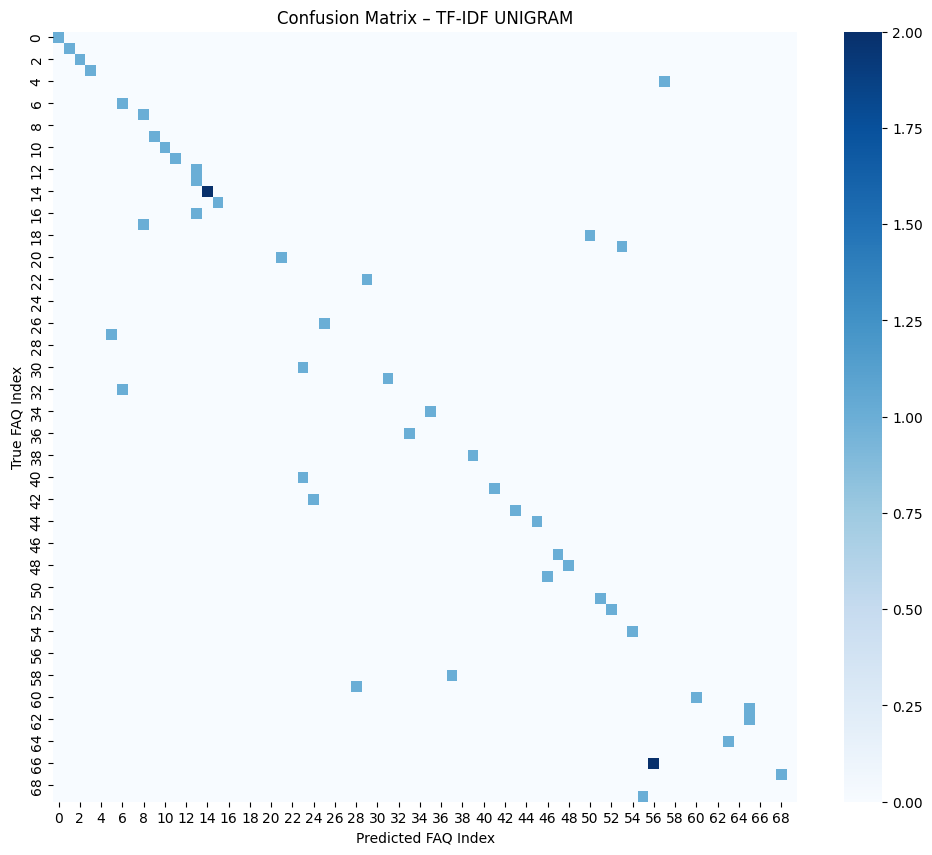

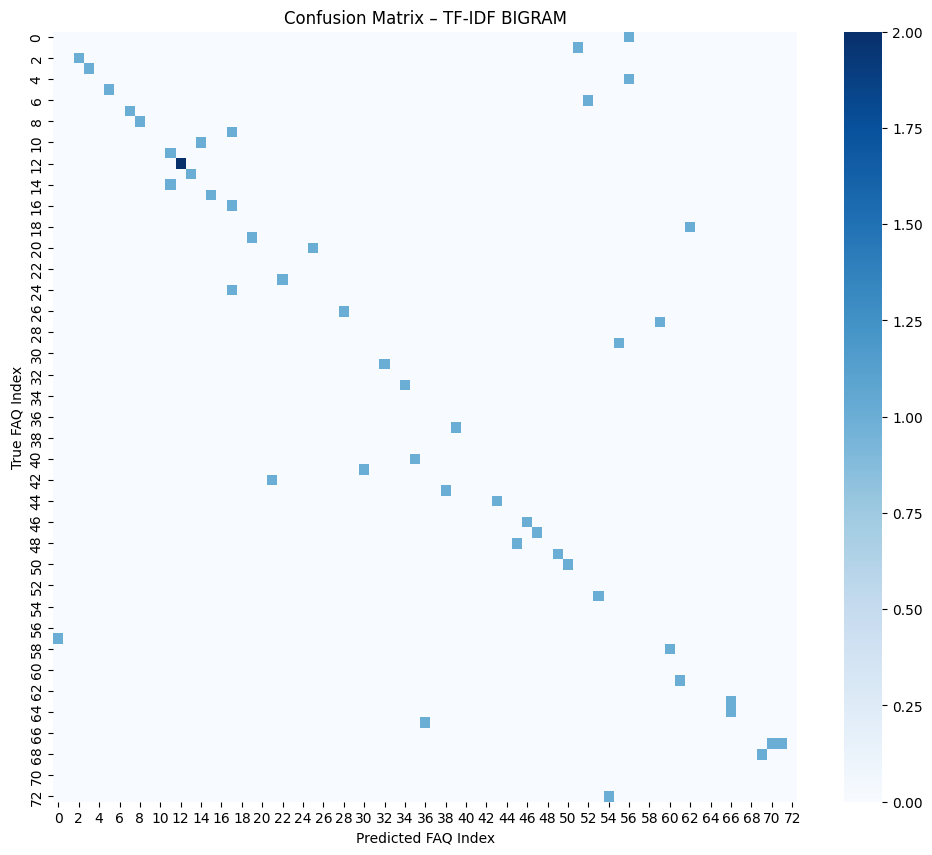

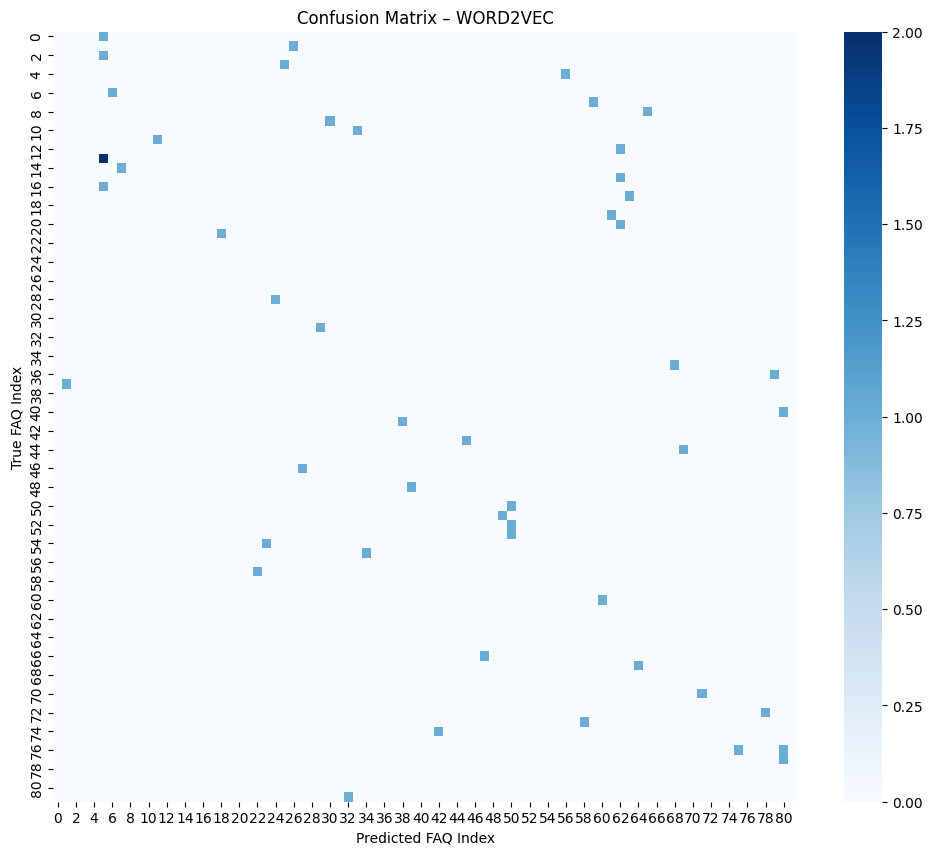

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"Confusion Matrix – {title}")
    plt.xlabel("Predicted FAQ Index")
    plt.ylabel("True FAQ Index")
    plt.show()

# UNIGRAM
plot_cm(y_true, y_pred_unigram, "TF-IDF UNIGRAM")

# BIGRAM
plot_cm(y_true, y_pred_bigram, "TF-IDF BIGRAM")

# WORD2VEC
plot_cm(y_true, y_pred_w2v, "WORD2VEC")

**Top-k Accuracy (Peringkat Evaluasi)**

In [ ]:
def top_k_accuracy_mat(sim_matrix, y_true, k=3):
    # ambil index FAQ dengan similarity tertinggi sebanyak k
    top_k = np.argsort(-sim_matrix, axis=1)[:, :k]
    hits = [(y_true[i] in top_k[i]) for i in range(len(y_true))]
    return np.mean(hits)

q_tfidf_unigram = unigram_vectorizer.transform(df_q["question_clean"])
sim_to_faq_unigram = cosine_similarity(q_tfidf_unigram, unigram_matrix)

q_tfidf_bigram = bigram_vectorizer.transform(df_q["question_clean"])
sim_to_faq_bigram = cosine_similarity(q_tfidf_bigram, bigram_matrix)

sim_matrix_w2v = cosine_similarity(q_vectors, faq_vectors)

print("=== TF-IDF UNIGRAM ===")
print("Top-1:", top_k_accuracy_mat(sim_to_faq_unigram, y_true, k=1))
print("Top-3:", top_k_accuracy_mat(sim_to_faq_unigram, y_true, k=3))
print("Top-5:", top_k_accuracy_mat(sim_to_faq_unigram, y_true, k=5))

print("=== TF-IDF BIGRAM ===")
print("Top-1:", top_k_accuracy_mat(sim_to_faq_bigram, y_true, k=1))
print("Top-3:", top_k_accuracy_mat(sim_to_faq_bigram, y_true, k=3))
print("Top-5:", top_k_accuracy_mat(sim_to_faq_bigram, y_true, k=5))

print("=== WORD2VEC ===")
print("Top-1:", top_k_accuracy_mat(sim_matrix_w2v, y_true, k=1))
print("Top-3:", top_k_accuracy_mat(sim_matrix_w2v, y_true, k=3))
print("Top-5:", top_k_accuracy_mat(sim_matrix_w2v, y_true, k=5))

=== TF-IDF UNIGRAM ===
Top-1: 0.42
Top-3: 0.72
Top-5: 0.78
=== TF-IDF BIGRAM ===
Top-1: 0.34
Top-3: 0.62
Top-5: 0.64
=== WORD2VEC ===
Top-1: 0.08
Top-3: 0.1
Top-5: 0.1


**Distribusi Nilai Cosine Similarity**

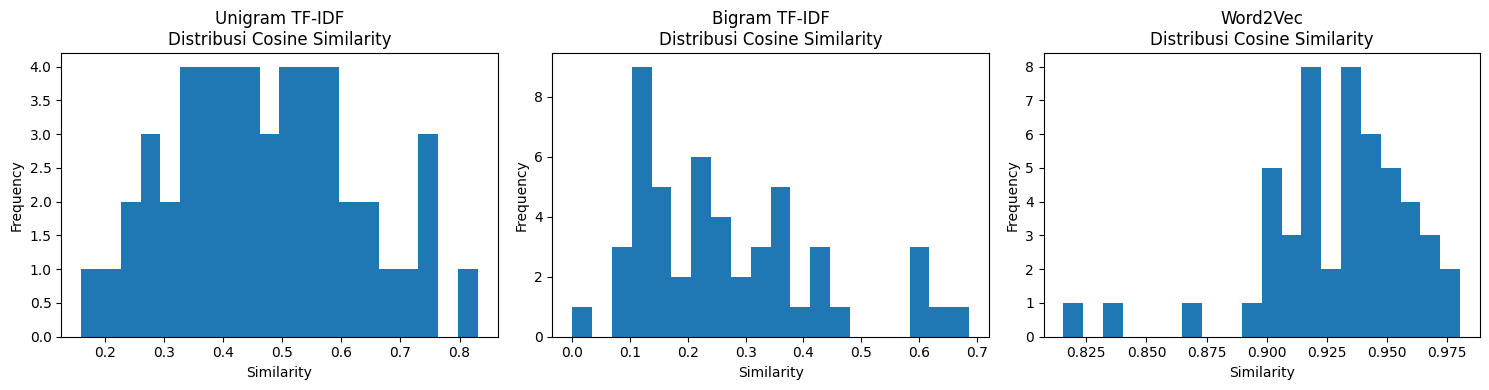

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

# UNIGRAM
plt.subplot(1,3,1)
plt.hist(sim_to_faq_unigram.max(axis=1), bins=20)
plt.title("Unigram TF-IDF\nDistribusi Cosine Similarity")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

# BIGRAM
plt.subplot(1,3,2)
plt.hist(sim_to_faq_bigram.max(axis=1), bins=20)
plt.title("Bigram TF-IDF\nDistribusi Cosine Similarity")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

# WORD2VEC
plt.subplot(1,3,3)
plt.hist(sim_matrix_w2v.max(axis=1), bins=20)
plt.title("Word2Vec\nDistribusi Cosine Similarity")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Barplot Error Tertinggi**

Menampilkan pertanyaan pengguna yang paling sering gagal diprediksi benar

In [ ]:
df_q['groundtruth'] = df_groundtruth['groundtruth'].values

def error_table(df_q, y_pred, label):
    df_temp = df_q.copy()
    df_temp["pred"] = y_pred
    df_temp["correct"] = (df_temp["groundtruth"] == df_temp["pred"])
    print(f"=== {label} ===")
    print("Jumlah benar vs salah:")
    print(df_temp["correct"].value_counts())
    print("\nPertanyaan yang salah:")
    df_errors = df_temp[~df_temp["correct"]][["question_clean", "groundtruth", "pred"]]
    display(df_errors)
    return df_temp

y_pred_unigram = np.argmax(sim_to_faq_unigram, axis=1)
y_pred_bigram  = np.argmax(sim_to_faq_bigram, axis=1)
y_pred_w2v     = np.argmax(sim_matrix_w2v, axis=1)

err_unigram = error_table(df_q, y_pred_unigram, "TF-IDF UNIGRAM")
err_bigram  = error_table(df_q, y_pred_bigram,  "TF-IDF BIGRAM")
err_w2v     = error_table(df_q, y_pred_w2v,     "WORD2VEC")

=== TF-IDF UNIGRAM ===
Jumlah benar vs salah:
correct
False    29
True     21
Name: count, dtype: int64

Pertanyaan yang salah:


question_clean  groundtruth  pred
1      bagaimana cara pengembalian dana tiket bioskop          490    54
2   cara transfer ke teman yang sesama pengguna sh...         1053  1055
4                  top shopeepay bisa lewat mana saja         1040   685
5       cara menggunakan voucher shopeefood bagaimana          853   268
7        menggunakan spaylater limit xtra aman enggak          417   358
8   bagaimana cara mengaktifkan spaylater buat bel...          391   399
9               kok enggak bisa bayar menggunakan cod          297    36
11  kenapa kok voucher gratis ongkir gabisa dipaka...           31   274
12    cara mengirim gambar di fitur chat bagaimana ya           29    30
13                  kalau pesanan cod gagal bagaimana          471    36
14  bagaimana caranya biar enggak dikenakan modus ...          920  1005
15                        klaim proteksi hp bagaimana          227   221
16  cara supaya enggak dikenakan modus penipuan le...          934  1005
17  maksimal berat kirim hemat kargo ekonomis bera...          458   467
18                syarat spinjam buat penjual tuh apa          846   428
20  apa saja dokumen yang dapat saya kirimkan buat...          504   505
22  cara tau kalau pengembalian dana sudah masuk k...          527   507
24    membeli produk di shopee dikenakan pajak enggak          337     7
26  iklan shopee live itu apaan buat promosi pas l...           14    15
27  kalau mau nge chat atau bertanya bertanya ke p...           28   622
29  memang kenapa kalau live di shopee menggunakan...            9    10
35  bikin nama toko di shopee ada syarat khususnya...         1145   683
38  kenapa ya akun shopee video dibatasi jadi engg...           20   530
40  live yang dianggap konten jelek di shopee live...            4   823
41  cara top saldo buat shopeepay merchant itu bag...         1040   685
42  voucher buat mencoba sample produk gratis di s...          259     5
44  biar iklan live shopee kita efektif cara kerja...           18    15
46  kesehatan video di shopee video itu maksudnya ...           19    10
48  apa bedanya pesanan yang langsung sama yang en...          992   991

=== TF-IDF BIGRAM ===
Jumlah benar vs salah:
correct
False    33
True     17
Name: count, dtype: int64

Pertanyaan yang salah:


question_clean  groundtruth  pred
0   bagaimana langkah nya bayar pesanan tapi mengg...          319   859
1      bagaimana cara pengembalian dana tiket bioskop          490    54
2   cara transfer ke teman yang sesama pengguna sh...         1053  1055
4                  top shopeepay bisa lewat mana saja         1040  1119
5       cara menggunakan voucher shopeefood bagaimana          853   871
6   kalau barang pesanan sudah sampai sudah di pes...          503   461
7        menggunakan spaylater limit xtra aman enggak          417   436
8   bagaimana cara mengaktifkan spaylater buat bel...          391   399
9               kok enggak bisa bayar menggunakan cod          297   324
11  kenapa kok voucher gratis ongkir gabisa dipaka...           31   274
13                  kalau pesanan cod gagal bagaimana          471   447
14  bagaimana caranya biar enggak dikenakan modus ...          920  1005
15                        klaim proteksi hp bagaimana          227   221
16  cara supaya enggak dikenakan modus penipuan le...          934  1005
17  maksimal berat kirim hemat kargo ekonomis bera...          458   467
18                syarat spinjam buat penjual tuh apa          846     0
19  setelah penilaian produk kita tuh tetap bisa n...          485   341
20  apa saja dokumen yang dapat saya kirimkan buat...          504   503
22  cara tau kalau pengembalian dana sudah masuk k...          527   507
24    membeli produk di shopee dikenakan pajak enggak          337   686
25  membeli barang grosir di shopee itu apa bedany...            1   640
26  iklan shopee live itu apaan buat promosi pas l...           14    18
27  kalau mau nge chat atau bertanya bertanya ke p...           28   897
28      lelang di shopee live itu maksudnya bagaimana            0   823
29  memang kenapa kalau live di shopee menggunakan...            9   649
34  aturan khusus buat live shopee video pas bulan...           13    24
35  bikin nama toko di shopee ada syarat khususnya...         1145   683
38  kenapa ya akun shopee video dibatasi jadi engg...           20    24
40  live yang dianggap konten jelek di shopee live...            4   823
41  cara top saldo buat shopeepay merchant itu bag...         1040  1064
42  voucher buat mencoba sample produk gratis di s...          259    24
44  biar iklan live shopee kita efektif cara kerja...           18    15
48  apa bedanya pesanan yang langsung sama yang en...          992   450

=== WORD2VEC ===
Jumlah benar vs salah:
correct
False    46
True      4
Name: count, dtype: int64

Pertanyaan yang salah:


question_clean  groundtruth  pred
0   bagaimana langkah nya bayar pesanan tapi mengg...          319  1115
1      bagaimana cara pengembalian dana tiket bioskop          490   386
2   cara transfer ke teman yang sesama pengguna sh...         1053  1134
4                  top shopeepay bisa lewat mana saja         1040  1035
5       cara menggunakan voucher shopeefood bagaimana          853   798
7        menggunakan spaylater limit xtra aman enggak          417   358
8   bagaimana cara mengaktifkan spaylater buat bel...          391  1134
9               kok enggak bisa bayar menggunakan cod          297   855
10              alamat yang salah bisa di edit enggak          545   285
11  kenapa kok voucher gratis ongkir gabisa dipaka...           31    25
12    cara mengirim gambar di fitur chat bagaimana ya           29   745
13                  kalau pesanan cod gagal bagaimana          471   861
14  bagaimana caranya biar enggak dikenakan modus ...          920  1089
15                        klaim proteksi hp bagaimana          227    57
16  cara supaya enggak dikenakan modus penipuan le...          934   623
17  maksimal berat kirim hemat kargo ekonomis bera...          458   472
18                syarat spinjam buat penjual tuh apa          846   489
19  setelah penilaian produk kita tuh tetap bisa n...          485   206
20  apa saja dokumen yang dapat saya kirimkan buat...          504   492
21  kalau belum menerima pengembalian dana padahal...          523   503
22  cara tau kalau pengembalian dana sudah masuk k...          527    56
23  berapa lama ya proses pengecekan barang buat p...          526   503
24    membeli produk di shopee dikenakan pajak enggak          337     1
25  membeli barang grosir di shopee itu apa bedany...            1   183
27  kalau mau nge chat atau bertanya bertanya ke p...           28   702
28      lelang di shopee live itu maksudnya bagaimana            0     6
29  memang kenapa kalau live di shopee menggunakan...            9   624
30  penjual star star di shopee itu siapa penting ...            3   176
31  misi shopee meter itu tugasnya apa biar skor k...           16     6
32  bagaimana cara mendapatkan koin gratis dari pr...           12   257
33  shopee barokah itu apa jualan barang halal saj...            2     6
34  aturan khusus buat live shopee video pas bulan...           13   272
35  bikin nama toko di shopee ada syarat khususnya...         1145   269
36  cara hapus atau ubah produk di keranjang belan...          598    45
38  kenapa ya akun shopee video dibatasi jadi engg...           20   757
39             misi misi di shopee meter itu buat apa           16     6
40  live yang dianggap konten jelek di shopee live...            4   596
41  cara top saldo buat shopeepay merchant itu bag...         1040  1134
42  voucher buat mencoba sample produk gratis di s...          259   255
43  cara bikin iklan live di shopee lewat aplikasi...           15   745
44  biar iklan live shopee kita efektif cara kerja...           18   745
45  boleh enggak mengadakan event gacha gacha berh...           17     9
46  kesehatan video di shopee video itu maksudnya ...           19     6
47  kalau ada yang mencolong hak cipta haki pas li...           11   823
48  apa bedanya pesanan yang langsung sama yang en...          992   445
49  cara lihat download faktur biaya iklan shopeef...          893   902


--- Visualisasi Distribusi Error (Rank-1) ---



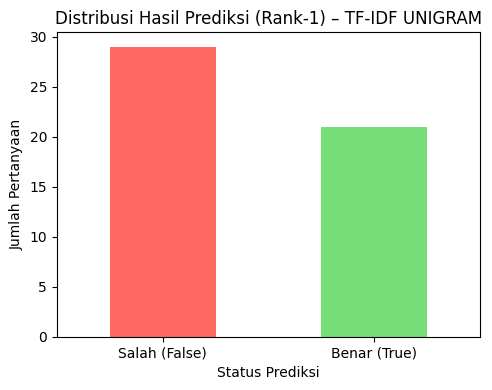

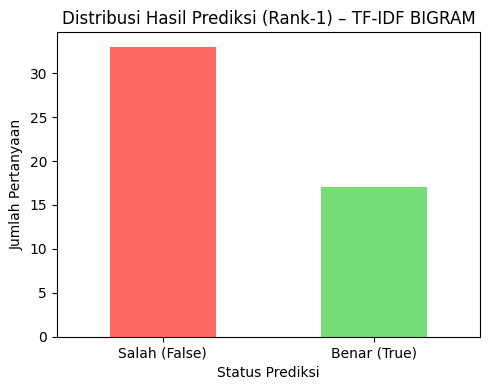

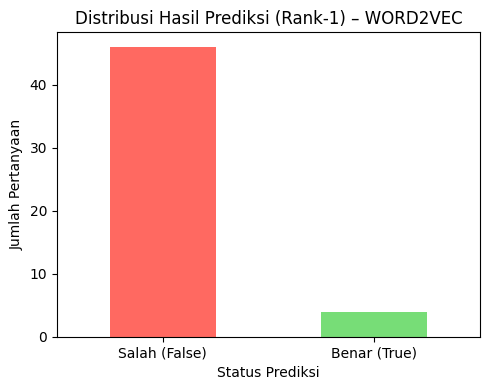

In [ ]:
def plot_error(df_temp, label):
    plt.figure(figsize=(5,4))
    df_temp["correct"].value_counts().plot(kind="bar", color=['#ff6961', '#77dd77'])
    plt.title(f"Distribusi Hasil Prediksi (Rank-1) – {label}")
    plt.xticks([0, 1], ['Salah (False)', 'Benar (True)'], rotation=0)
    plt.xlabel("Status Prediksi")
    plt.ylabel("Jumlah Pertanyaan")
    plt.tight_layout()
    plt.show()

print("\n--- Visualisasi Distribusi Error (Rank-1) ---\n")
plot_error(err_unigram, "TF-IDF UNIGRAM")
plot_error(err_bigram,  "TF-IDF BIGRAM")
plot_error(err_w2v,     "WORD2VEC")

**t-SNE FAQ Clustering**

Menggunakan kolom kategori sebagai label warna untuk melihat pola clustering

Running t-SNE for Word2Vec...


/tmp/ipython-input-2208774954.py:28: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(*scatter.legend_elements(), loc="lower left",


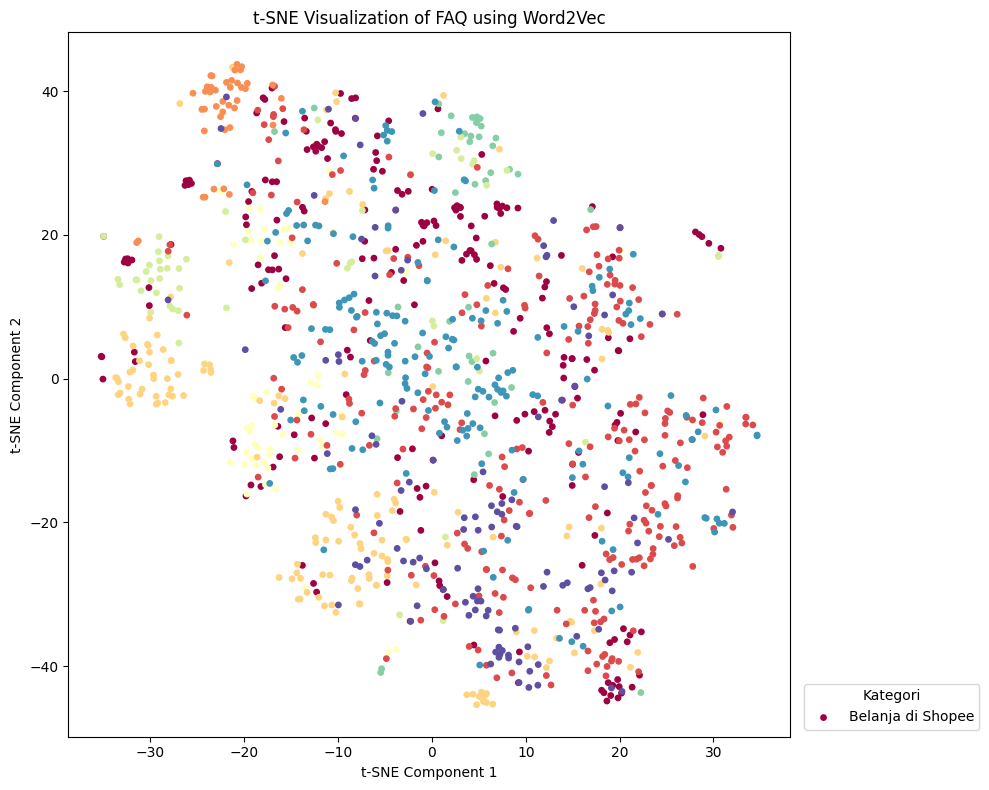

Running t-SNE for TF-IDF Unigram...


/tmp/ipython-input-2208774954.py:28: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(*scatter.legend_elements(), loc="lower left",


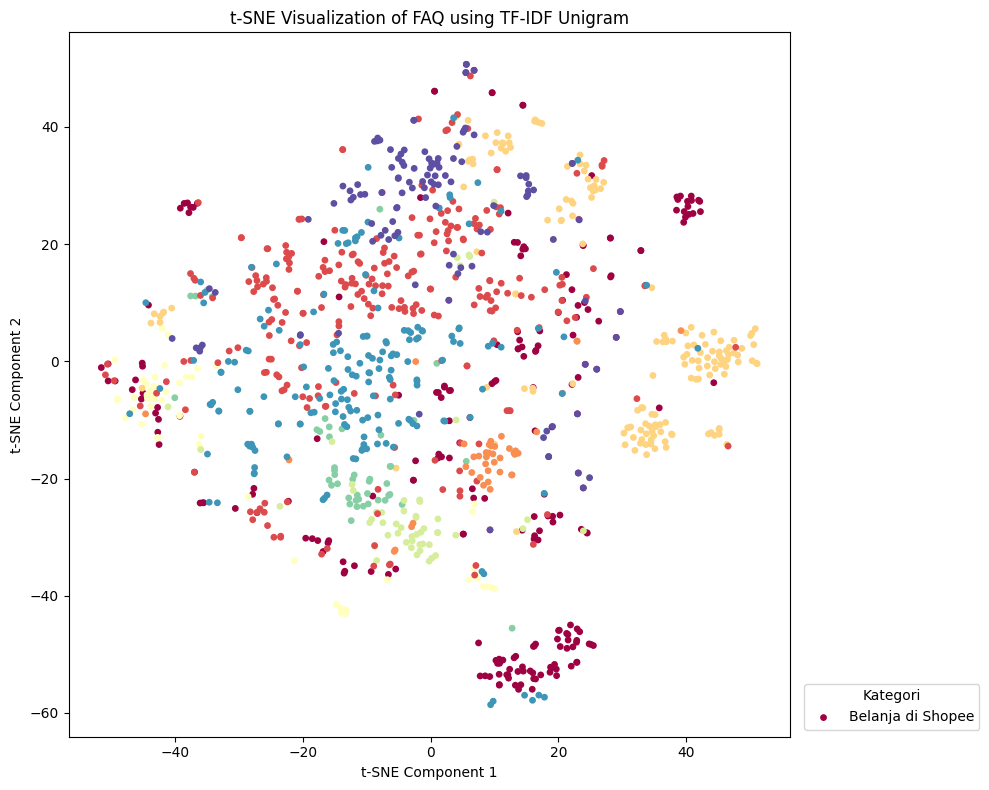

Running t-SNE for TF-IDF Bigram...


/tmp/ipython-input-2208774954.py:28: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(*scatter.legend_elements(), loc="lower left",


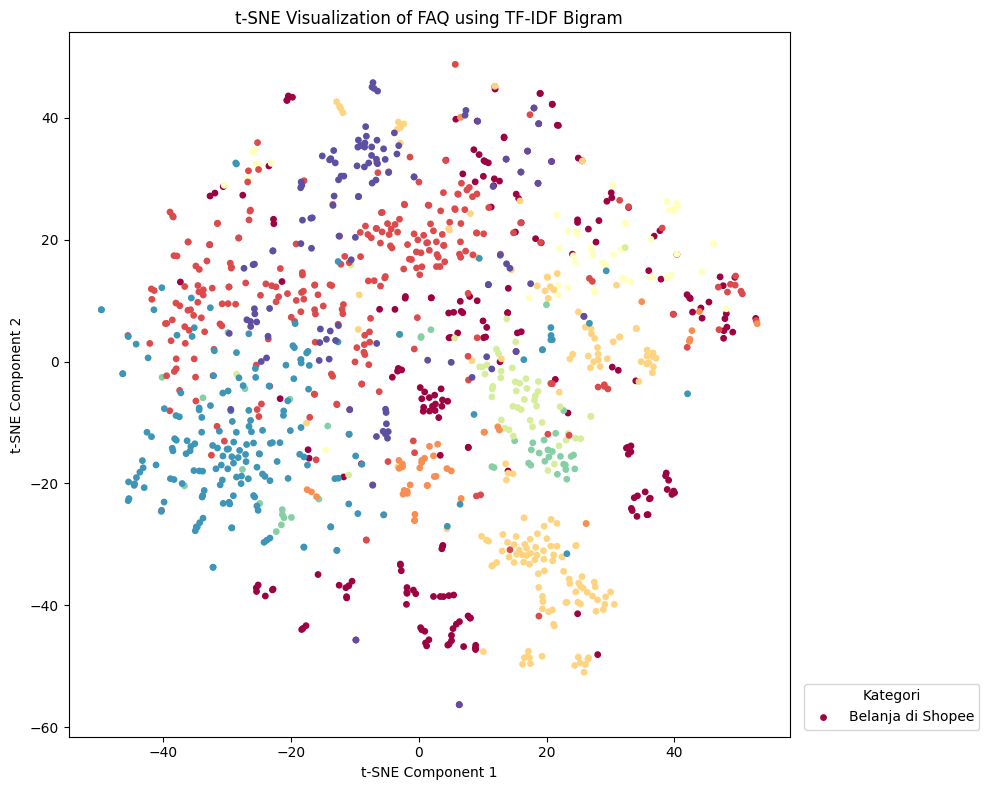

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Mengambil vektor dari Word2Vec (dense)
faq_vectors_w2v = faq_vectors
# Mengambil matriks Unigram TF-IDF (sparse, perlu diubah ke dense)
faq_vectors_unigram = unigram_matrix.toarray()
# Mengambil matriks Bigram TF-IDF (sparse, perlu diubah ke dense)
faq_vectors_bigram = bigram_matrix.toarray()

# Mengambil label warna (kategori) dari df_f
labels = df_f['kategori'].astype('category').cat.codes
category_names = df_f['kategori'].unique()

def run_tsne_and_plot(vectors, title_suffix, labels, category_names):
    print(f"Running t-SNE for {title_suffix}...")

    # Parameter t-SNE yang umum
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='random')
    faq_tsne = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(faq_tsne[:, 0], faq_tsne[:, 1], c=labels, s=15, cmap='Spectral')
    plt.title(f"t-SNE Visualization of FAQ using {title_suffix}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(*scatter.legend_elements(), loc="lower left",
        title="Kategori", labels=category_names, bbox_to_anchor=(1.01, 0))
    plt.tight_layout()
    plt.show()

run_tsne_and_plot(faq_vectors_w2v, "Word2Vec", labels, category_names)
run_tsne_and_plot(faq_vectors_unigram, "TF-IDF Unigram", labels, category_names)
run_tsne_and_plot(faq_vectors_bigram, "TF-IDF Bigram", labels, category_names)